In [91]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane

Tensor-network quantum circuits {#tn_circuits}
===============================

::: {.meta}
:property=\"og:description\": This demonstration explains how to
simulate tensor-network quantum circuits. :property=\"og:image\":
<https://pennylane.ai/qml/_images/thumbnail_tn_circuits.png>
:::

::: {.related}
tutorial\_variational\_classifier Variational classifier
:::

*Authors: Diego Guala*^1^ *, Esther Cruz-Rico*^2^ *, Shaoming Zhang*^2^
*, Juan Miguel Arrazola*^1^ *--- Posted: 29 March 2022. Last updated: 27
June 2022.*

| ^1^ Xanadu, Toronto, ON, M5G 2C8, Canada
| ^2^ BMW Group, Munich, Germany

This demonstration explains how to use PennyLane templates to design and
implement tensor-network quantum circuits as in Ref.. Tensor-network
quantum circuits emulate the shape and connectivity of tensor networks
such as matrix product states and tree tensor networks.

We begin with a short introduction to tensor networks and explain their
relationship to quantum circuits. Next, we illustrate how PennyLane\'s
templates make it easy to design, customize, and simulate these
circuits. Finally, we show how to use the circuits to learn to classify
the bars and stripes data set. This is a toy problem where the template
learns to recognize whether an image exhibits horizontal stripes or
vertical bars.

Tensors and Tensor Networks
---------------------------

Tensors are multi-dimensional arrays of numbers. Intuitively, they can
be interpreted as a generalization of scalars, vectors, and matrices.
Tensors can be described by their rank, indices, and the dimension of
the indices. The rank is the number of indices in a tensor --- a scalar
has rank zero, a vector has rank one, and a matrix has rank two. The
dimension of an index is the number of values that index can take. For
example, a vector with three elements has one index that can take three
values. This is vector is therefore a rank one tensor and its index has
dimension three.

To define tensor networks, it is important to first understand tensor
contraction. Two or more tensors can be contracted by summing over
repeated indices. In diagrammatic notation, the repeated indices appear
as lines connecting tensors, as in the figure below. We see two tensors
of rank two connected by one repeated index, $k$. The dimension of the
repeated index is called the bond dimension.

![image](../demonstrations/tn_circuits/simple_tn_color.PNG){.align-center
width="50.0%"}

The contraction of the tensors above is equivalent to the standard
matrix multiplication formula and can be expressed as

$$C_{ij} = \sum_{k}A_{ik}B_{kj},$$

where $C_{ij}$ denotes the entry for the $i$-th row and $j$-th column of
the product $C=AB$.

A tensor network is a collection of tensors where a subset of all
indices are contracted. As mentioned above, we can use diagrammatic
notation to specify which indices and tensors will be contracted
together by connecting individual tensors with lines. Tensor networks
can represent complicated operations involving several tensors with many
indices contracted in sophisticated patterns.

Two well-known tensor network architectures are matrix product states
(MPS) and tree tensor networks (TTN). These follow specific patterns of
connections between tensors and can be extended to have many or few
indices. Examples of these architectures with only a few tensors can be
seen in the figure below. An MPS is shown on the left and a TTN on the
right.

![image](../demonstrations/tn_circuits/MPS_TTN_Color.PNG){.align-center
width="50.0%"}

These tensor networks are commonly used to efficiently represent certain
many-body quantum states. Every quantum circuit can be represented as a
tensor network, with the bond dimension dependent on the width and
connectivity of the circuit. Moreover, one can design quantum circuits
that have the same connectivity as well-known tensor networks like MPS
and TTN. We call these **tensor-network quantum circuits**. Note that
the connectivity of a tensor network is related to how entanglement is
distributed and how correlations spread in the resulting tensor-network
quantum circuit. We therefore design circuits based on the tensor
networks that best capture the information we want to extract.

In tensor-network quantum circuits, the tensor network architecture acts
as a guideline for the shape of the quantum circuit. More specifically,
the tensors in the tensor networks above are replaced with unitary
operations to obtain quantum circuits, as illustrated in the figure
below.

![image](../demonstrations/tn_circuits/MPS_TTN_Circuit_Color.PNG){.align-center
width="70.0%"}

Since the unitary operations $U_1$ to $U_3$ are in principle completely
general, it is not always clear how to implement them with a specific
gate set. Instead, we can replace the unitary operations with
variational quantum circuits determined by a specific template of
choice. The PennyLane tensor network templates allow us to do precisely
this: implement tensor-network quantum circuits with user-defined
circuit ansatze as the unitary operations. In this sense, just as a
template is a strategy for arranging parametrized gates, tensor-network
quantum circuits are strategies for structuring circuit templates. They
can therefore be interpreted as templates of templates, i.e., as
meta-templates.

PennyLane Implementation
------------------------

We now demonstrate how to use PennyLane to build and simulate
tensor-network quantum circuits.

The first step is to define the circuit that will be broadcast into the
tensor network shape. We call this a block. The block defines a
variational quantum circuit that takes the position of tensors in the
network.


In [92]:
import pennylane as qml
from pennylane import numpy as np


def block(weights, wires):
    qml.RX(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

With the block defined, we can build the full tensor-network quantum
circuit. The following code broadcasts the above block into the shape of
an MPS tensor network and computes the expectation value of a Pauli Z
operator on the bottom qubit.


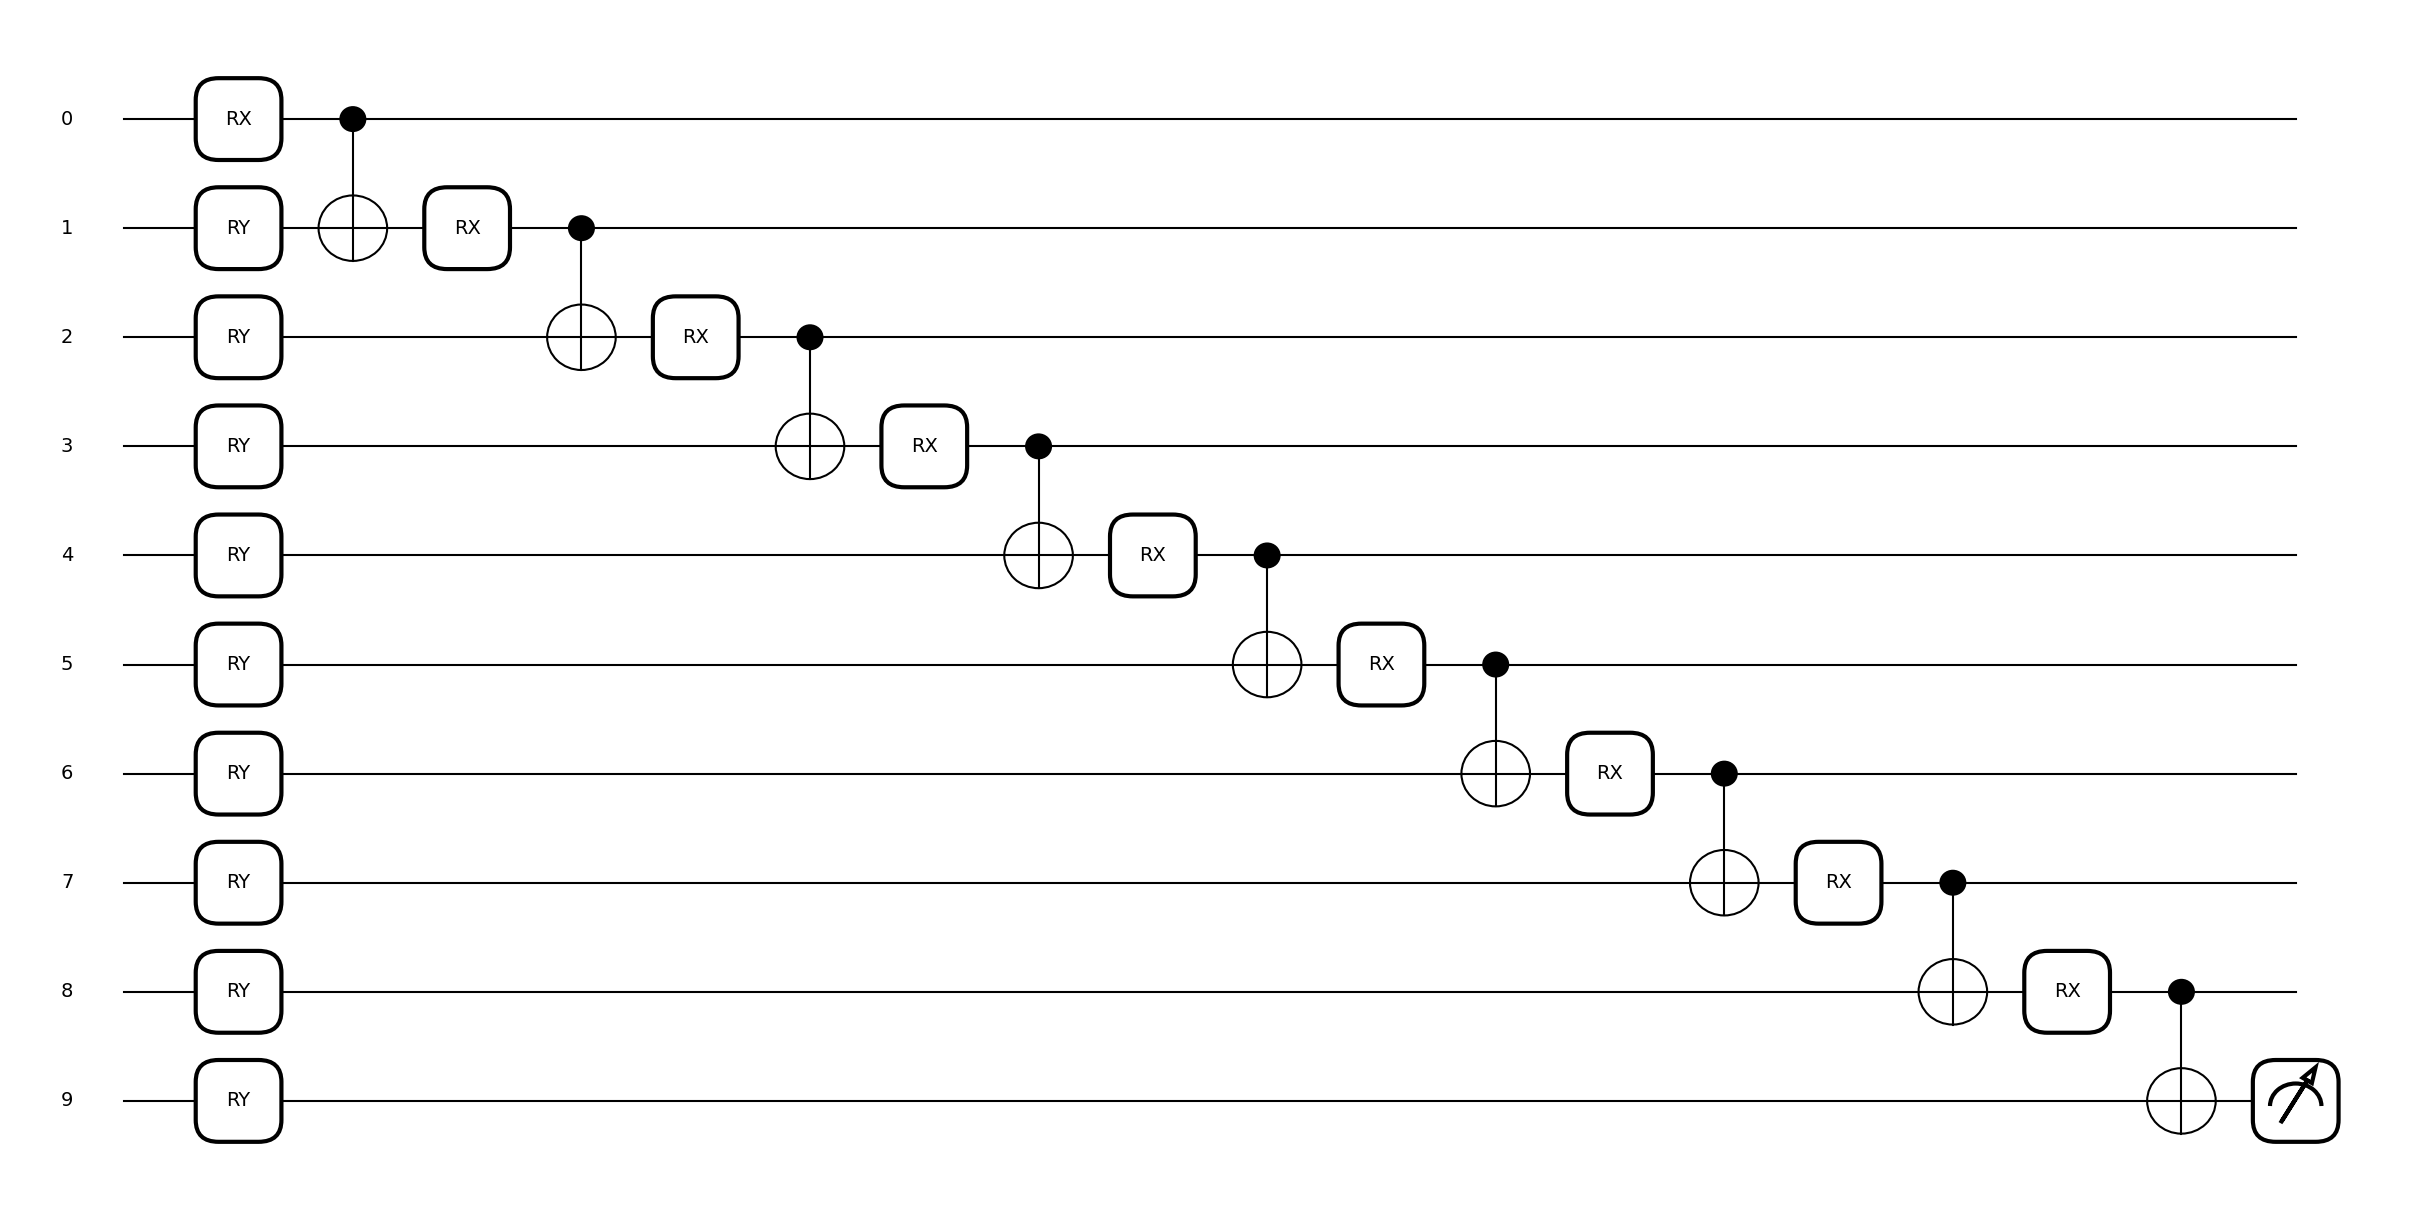

In [93]:
dev = qml.device("default.qubit", wires=10)


@qml.qnode(dev, interface="autograd")
def circuit(template_weights):
    qml.MPS(
        wires=range(10),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=9))


np.random.seed(1)
weights = np.random.random(size=[9, 2])
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(weights)
fig.set_size_inches((24, 12))

Using the `~pennylane.MPS`{.interpreted-text role="class"} template we
can easily change the block type, depth, and size. For example, the
block can contain a template like
`~pennylane.StronglyEntanglingLayers`{.interpreted-text role="class"},
yielding a deeper block.


In [94]:
def deep_block(weights, wires):
    qml.StronglyEntanglingLayers(weights, wires)

We can use the `~pennylane.MPS`{.interpreted-text role="class"} template
again and simply set `n_params_block = 3` to suit the new block.


In [95]:
dev = qml.device("default.qubit", wires=4)


@qml.qnode(dev, interface="autograd")
def circuit(template_weights):
    qml.MPS(
        wires=range(4),
        n_block_wires=2,
        block=deep_block,
        n_params_block=3,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=3))

To ensure that the weights of the block and `template_weights` sent to
the `~pennylane.MPS`{.interpreted-text role="class"} template are
compatible, we use the
`~pennylane.StronglyEntanglingLayers.shape`{.interpreted-text
role="class"} function and replicate the elemnts for the number of
expected blocks. Since this example will have three blocks, we replicate
the elements three times using `[list]*3`. The resulting circuit is
illustrated in the figure below the code. Note that this circuit retains
the layout of an MPS, but each block is now a deeper circuit with more
gates. Both this circuit and the previous circuit can be represented by
an MPS with a bond dimension of two.


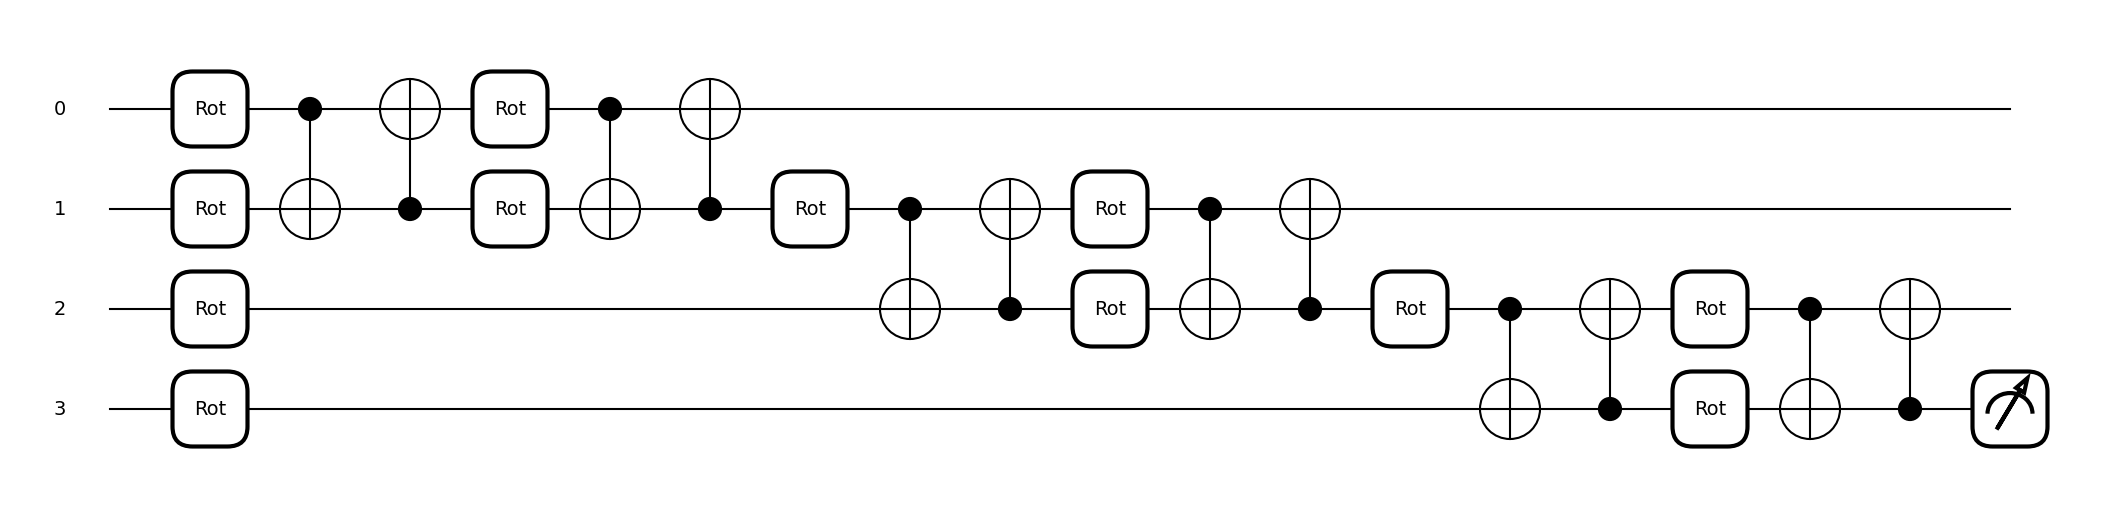

In [96]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
template_weights = [np.random.random(size=shape)] * 3
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(template_weights)

In addition to deep blocks, we can easily expand to wider blocks with
more input wires. In the next example, we use the
`~pennylane.SimplifiedTwoDesign`{.interpreted-text role="class"}
template as the block.


In [97]:
def wide_block(weights, wires):
    qml.SimplifiedTwoDesign(initial_layer_weights=weights[0], weights=weights[1], wires=wires)

To implement this wider block, we can use the
`~pennylane.MPS`{.interpreted-text role="class"} template as before. To
account for the extra wires per block, we simply set the `n_block_wires`
argument to a higher number. The figure below shows the resulting
circuit. Notice that, in the circuit diagram, gates are left-justified.
Therefore parts of later blocks appear near the beginning of the
circuit. Furthermore, this circuit has a higher bond dimension than the
previous ones and would correspond to an MPS with a bond dimension of
four.


/usr/local/lib/python3.10/dist-packages/pennylane/math/single_dispatch.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar.register_function("builtins", "shape", lambda x: np.array(x).shape)
/usr/local/lib/python3.10/dist-packages/pennylane/math/single_dispatch.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar.register_function("builtins", "ndim", lambda x: np.ndim(np.array(x)))
/usr/local/lib/python3.10/dist-packages/pennylane/operation.py:1027: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or

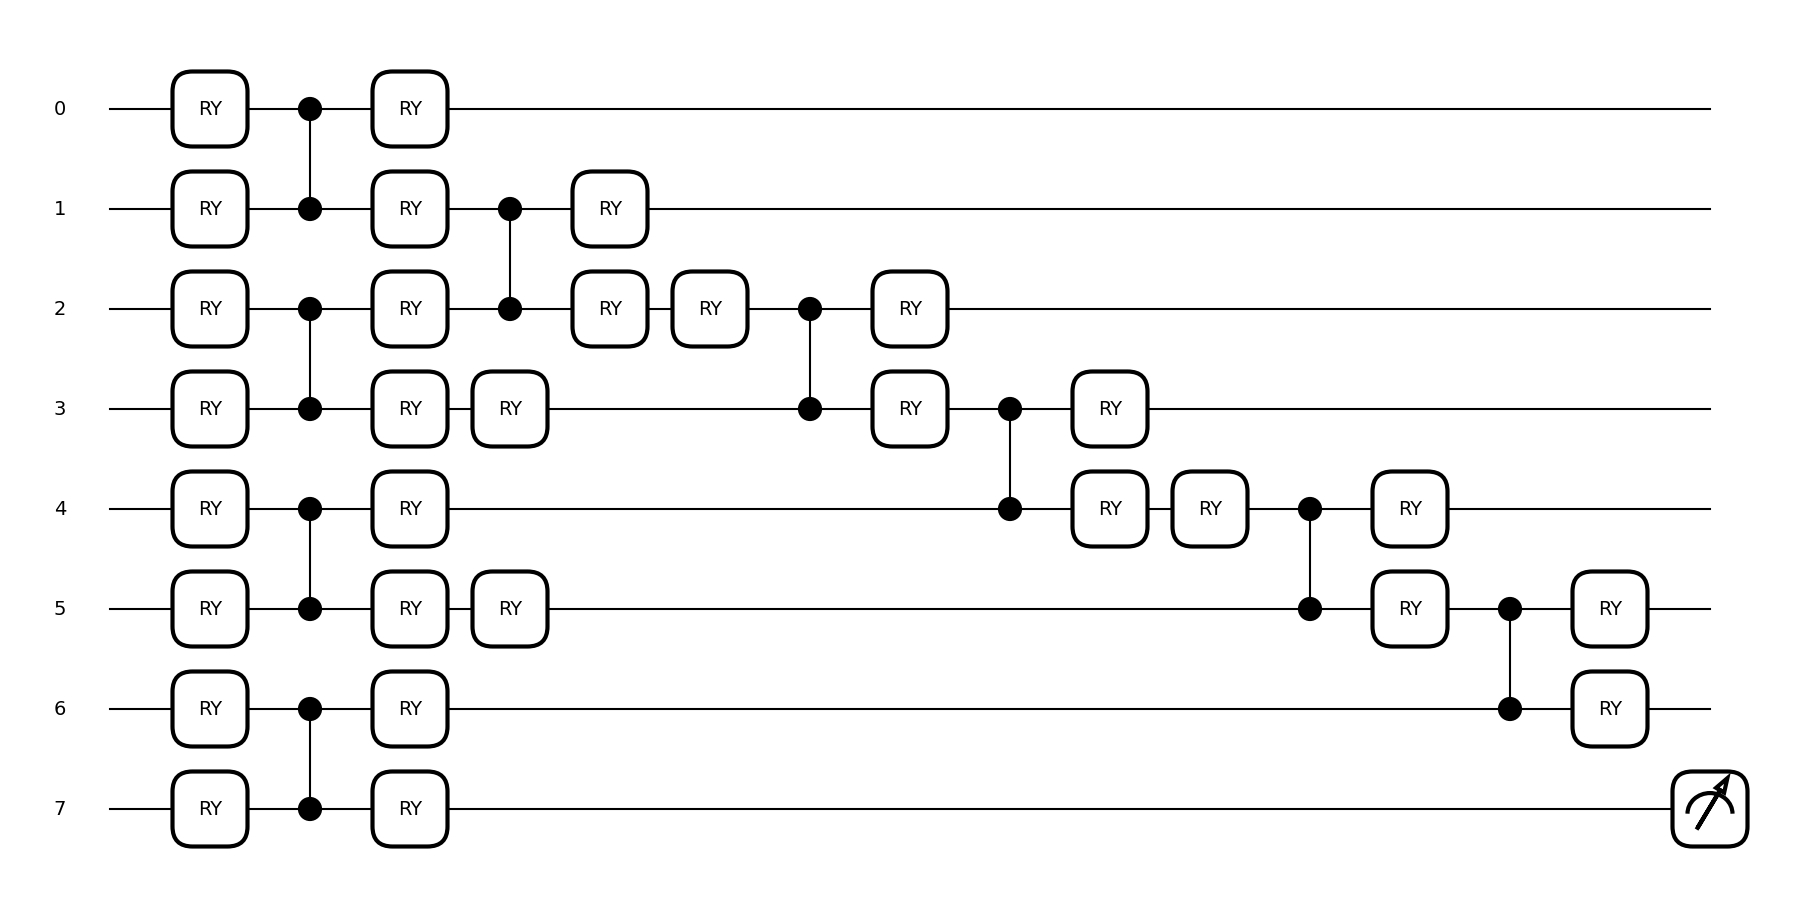

In [98]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev, interface="autograd")
def circuit(template_weights):
    qml.MPS(
        wires=range(8),
        n_block_wires=4,
        block=wide_block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=7))


shapes = qml.SimplifiedTwoDesign.shape(n_layers=1, n_wires=4)
weights = [np.random.random(size=shape) for shape in shapes]
template_weights = [weights] * 3
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(template_weights)

We can also broadcast a block to the tree tensor network architecture by
using the `~pennylane.TTN`{.interpreted-text role="class"} template.


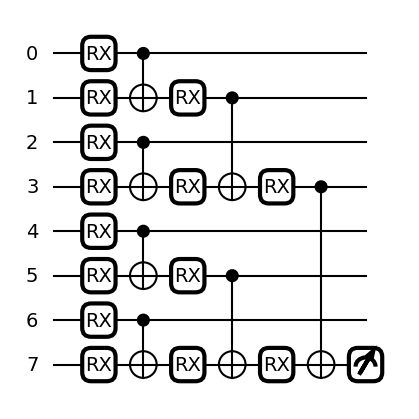

In [99]:
def block(weights, wires):
    qml.RX(weights[0], wires=wires[0])
    qml.RX(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)


dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev, interface="autograd")
def circuit(template_weights):
    qml.TTN(
        wires=range(8),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=7))


weights = np.random.random(size=[7, 2])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(weights)
fig.set_size_inches((4, 4))

Classifying the bars and stripes data set
=========================================

Next, we use a tensor-network quantum circuit to tackle a toy machine
learning problem. For this, we use the bars and stripes data set and
optimize a parametrized circuit to label the images as either bars or
stripes. The data set is composed of binary black and white images of
size $n \times n$ pixels. In images that should receive the bars label,
all pixels in any given column have the same color. In images with the
stripes label, all pixels in any given row have the same color. The full
data set for $4\times 4$ images is shown in the image below:

![](../demonstrations/tn_circuits/BAS.png){.align-center height="300px"}

A quantum circuit that successfully performs this task accepts any image
from the data set as input and outputs the correct label. We will
therefore choose a data encoding strategy that can record the input
image in a qubit register, a processing circuit that can analyze the
data, and a final measurement that can serve as a label of either
stripes or bars.

The first step is to generate the bars and stripes data set. For
$2\times 2$ images, we can manually define the full data set, giving
white pixels a value of 1 and black pixels a value of 0:


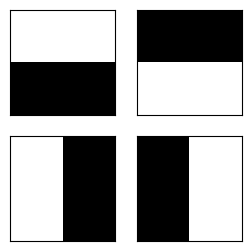

In [100]:
import matplotlib.pyplot as plt

BAS = [[1, 1, 0, 0], [0, 0, 1, 1], [1, 0, 1, 0], [0, 1, 0, 1]]
j = 1
plt.figure(figsize=[3, 3])
for i in BAS:
    plt.subplot(2, 2, j)
    j += 1
    plt.imshow(np.reshape(i, [2, 2]), cmap="gray")
    plt.xticks([])
    plt.yticks([])

The next step is to define the parameterized quantum circuit that will
be trained to label the images. This involves determining the block and
the tensor-network architecture. For the block, a circuit consisting of
`~pennylane.RY`{.interpreted-text role="class"} rotations and
`~pennylane.CNOT`{.interpreted-text role="class"} gates suffices for
this simple data set.


In [101]:
def block(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

As for the tensor-network architecture, we use the tree tensor-network
quantum circuit. We use
`~pennylane.BasisStatePreparation`{.interpreted-text role="class"} to
encode the input images. The following code implements the
`~pennylane.BasisStatePreparation`{.interpreted-text role="class"}
encoding, followed by a `~pennylane.TTN`{.interpreted-text role="class"}
circuit using the above `block`. Finally, we compute the expectation
value of a `~pennylane.PauliZ`{.interpreted-text role="class"}
measurement as the output. The circuit diagram below shows the full
circuit. The `~pennylane.BasisStatePreparation`{.interpreted-text
role="class"} encoding appears in the initial
`~pennylane.PauliX`{.interpreted-text role="class"} gates.


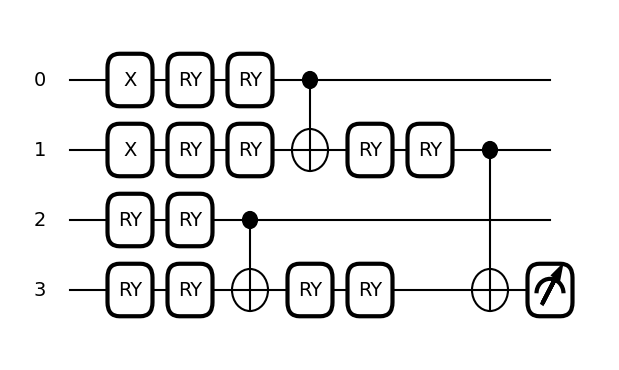

In [102]:
dev = qml.device("default.qubit", wires=4)


@qml.qnode(dev, interface="autograd")
def circuit(image, template_weights):
    qml.BasisStatePreparation(image, wires=range(4))
    qml.TTN(
        wires=range(4),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=3))


weights = np.random.random(size=[3, 2])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(BAS[0], weights)
fig.set_size_inches((6, 3.5))

When the output of the above circuit is less than zero, we label the
image \"stripes\", otherwise we label it \"bars\". Based on these
labels, we define a cost function to train the circuit. The cost
function in the following code adds the expectation value result if the
label should be negative and subtracts the result if the label should be
positive. In other words, the cost will be minimized when the stripes
images output negative one and the bars images output positive one.


In [103]:
def costfunc(params):
    cost = 0
    for i in range(len(BAS)):
        if i < len(BAS) / 2:
            cost += circuit(BAS[i], params)
        else:
            cost -= circuit(BAS[i], params)
    return cost

Finally, we initialize the parameters and use PennyLane's built-in
optimizer train the circuit over 100 iterations. This optimizer will
attempt to minimize the cost function.


In [104]:
params = np.random.random(size=[3, 2], requires_grad=True)
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)

for k in range(100):
    if k % 20 == 0:
        print(f"Step {k}, cost: {costfunc(params)}")
    params = optimizer.step(costfunc, params)

Step 0, cost: -0.19014484428429757
Step 20, cost: -3.9999999987683417
Step 40, cost: -3.9999999999999996
Step 60, cost: -4.0
Step 80, cost: -3.999999999999999


With the circuit trained and the parameters stored in `params`, we can
now show the full circuits and the resulting output for each image.


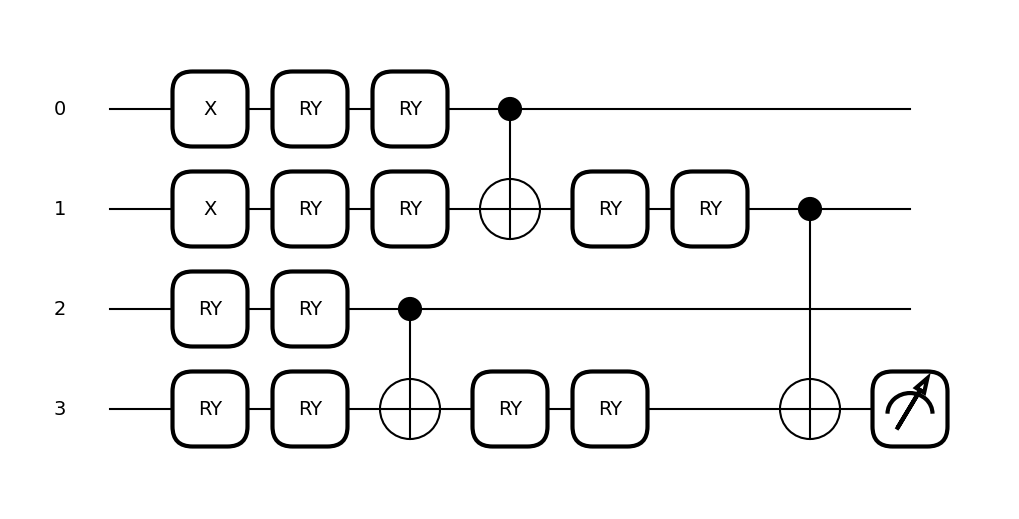

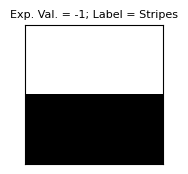

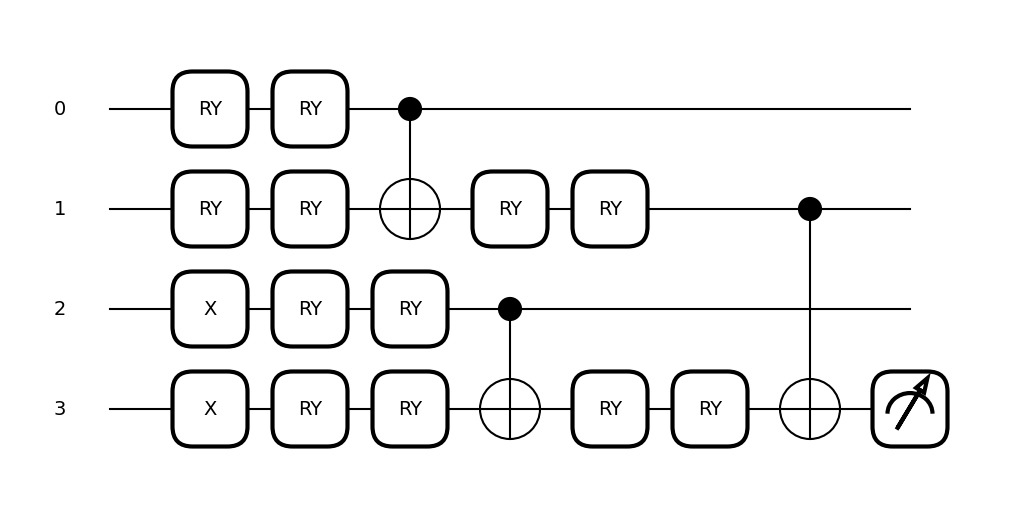

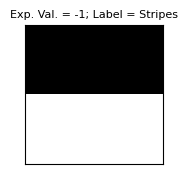

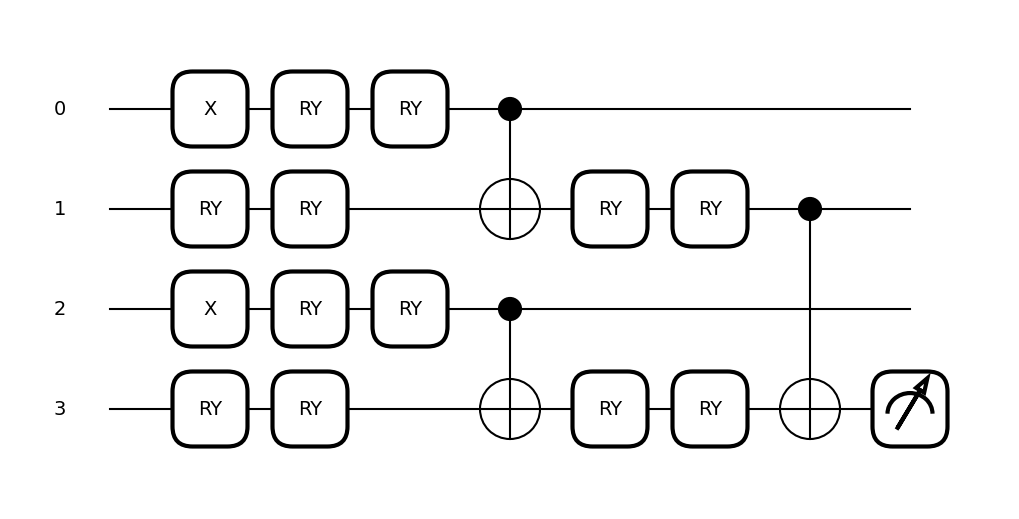

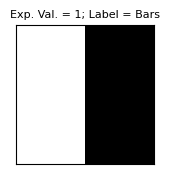

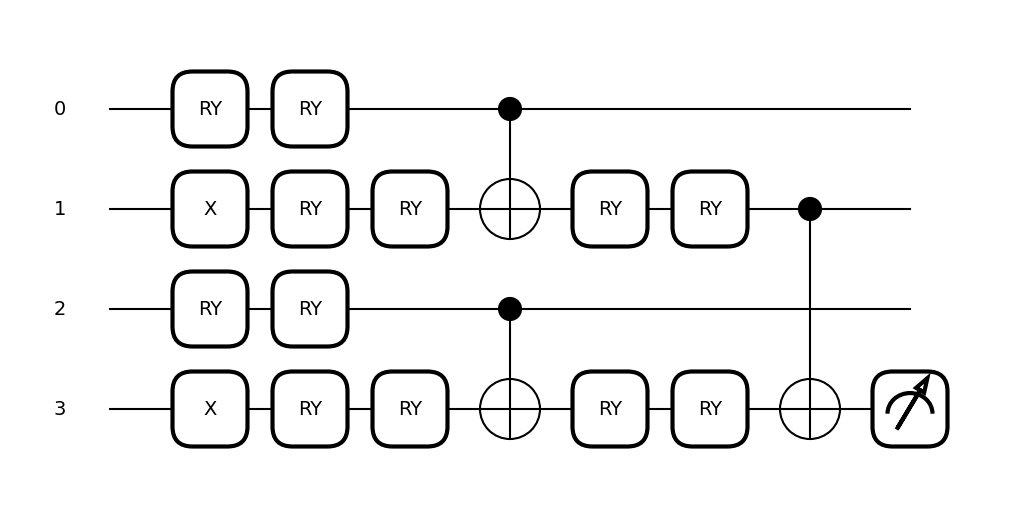

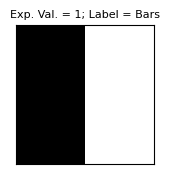

In [105]:
for image in BAS:
    fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(image, params)
    plt.figure(figsize=[1.8, 1.8])
    plt.imshow(np.reshape(image, [2, 2]), cmap="gray")
    plt.title(
        f"Exp. Val. = {circuit(image,params):.0f};"
        + f" Label = {'Bars' if circuit(image,params)>0 else 'Stripes'}",
        fontsize=8,
    )
    plt.xticks([])
    plt.yticks([])

The resulting labels are all correct. For images with stripes, the
circuit outputs an expectation value of minus one, corresponding to
stripes and for images with bars the circuit outputs an expectation
value of positive one, corresponding to bars.

References {#tn_circuits_references}
==========

About the authors
=================
